In [1]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
import warnings 

import scipy.stats as stats
import matplotlib.pyplot as plt  

from time import time
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore') 

%matplotlib inline

In [2]:
# Загрузка данных
books = pd.read_csv('data/books.csv')
book_tags = pd.read_csv('data/book_tags.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

# <center> **1. Описание данных**

Для построения рекомендательной системы использованы данные с платформы kaggle [goodbooks-10k](https://www.kaggle.com/datasets/zygmunt/goodbooks-10k)

Для работы были выбраны файлы: books.csv, book_tags.csv, ratings.csv, tags.csv 

### **books.csv**

Файл содержит информацию о книгах и их рейтингах. Всего 10,000 записей с 23 признаками.

#### **Описание признаков:**

**Идентификаторы:**

+ id - уникальный идентификатор записи (int64)
+ book_id - идентификатор книги (int64)
+ best_book_id - идентификатор лучшей версии книги (int64)
+ work_id - идентификатор произведения (int64)

**Информация о книге:**

+ books_count - количество версий книги (int64)
+ isbn - ISBN книги (object, 9,300 значений)
+ isbn13 - 13-значный ISBN (float64, 9,415 значений)
+ authors - авторы книги (object)
+ original_publication_year - год первоначальной публикации (float64, 9,979 значений)
+ original_title - оригинальное название (object, 9,415 значений)
+ title - название книги (object)

**Языковые характеристики:**

+ language_code - код языка (object, 8,916 значений)

**Рейтинги:**

+ average_rating - средний рейтинг (float64)
+ ratings_count - общее количество оценок (int64)
+ work_ratings_count - количество оценок произведения (int64)
+ work_text_reviews_count - количество текстовых обзоров (int64)
+ ratings_1, ratings_2, ratings_3, ratings_4, ratings_5 - количество оценок с 1 по 5 звезд (int64)

**Изображения:**

+ image_url - URL полного изображения (object)
+ small_image_url - URL уменьшенного изображения (object)

**________________________________________________________________________________________________________________________________________**

### **book_tags.csv**

Датасет представляет собой связь многие-ко-многим между книгами и тегами, где каждый тег может быть присвоен нескольким книгам, а каждая книга может иметь несколько тегов. Признак count указывает на частоту использования тега для конкретной книги.

#### **Описание признаков:**

+ goodreads_book_id - идентификатор книги на Goodreads (int64)
+ tag_id - идентификатор тега (int64)
+ count - количество присвоений данного тега книге (int64)

**________________________________________________________________________________________________________________________________________**

### **tags.csv**

Датасет tags.csv содержит соответствие идентификаторов тегов их названиям. Всего 34,252 записи с 2 признаками:

#### **Описание признаков:**

+ tag_id - идентификатор тега (int64)
+ tag_name - название тега (object)

**________________________________________________________________________________________________________________________________________**

### **ratings.csv**

Датасет ratings.csv содержит информацию о рейтингах, присвоенных книгам пользователями. Всего 981,756 записей с 3 признаками:

#### **Описание признаков:**

+ book_id - идентификатор книги (int64)
+ user_id - идентификатор пользователя (int64)
+ rating - оценка, присвоенная пользователем книге (int64)

# <center> **2. Подготовка данных**

In [3]:
# Список числовых признаков
books_numeric = [x for x in books.columns if books[x].dtype != 'object']

# Проверим диапазон значений
for col in books_numeric:
    print(f'{col}: {books[col].min()} - {books[col].max()}')
    
    
# Преобразование типов данных
# uint16: books_count
# int16: original_publication_year
# uint32: остальные целочисленные, кроме идентификаторов
# int64: isbn13
# float16: average_rating
books['books_count'] = books['books_count'].astype('uint16')
books['original_publication_year'] = books['original_publication_year'].astype('Int16')
books['isbn13'] = books['isbn13'].astype('Int64')
books['average_rating'] = books['average_rating'].astype('float16')
for col in ['books_count', 'ratings_count', 'work_ratings_count', 'work_text_reviews_count', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']:
    books[col] = books[col].astype('uint32')


id: 1 - 10000
book_id: 1 - 33288638
best_book_id: 1 - 35534230
work_id: 87 - 56399597
books_count: 1 - 3455
isbn13: 195170342.0 - 9790007672390.0
original_publication_year: -1750.0 - 2017.0
average_rating: 2.47 - 4.82
ratings_count: 2716 - 4780653
work_ratings_count: 5510 - 4942365
work_text_reviews_count: 3 - 155254
ratings_1: 11 - 456191
ratings_2: 30 - 436802
ratings_3: 323 - 793319
ratings_4: 750 - 1481305
ratings_5: 754 - 3011543


In [4]:
# book_tags['count'] -> uint32
book_tags['count'] = book_tags['count'].astype('uint32')
# ratings['rating'] -> uint8
ratings['rating'] = ratings['rating'].astype('uint8')

In [5]:
# Из books удалим признаки со ссылками на изображения
books = books.drop(['image_url', 'small_image_url'], axis=1)

In [6]:
# Проверка на наличие полных дубликатов
print(f'Количество дубликатов в books: {books.duplicated().sum()}')
print(f'Количество дубликатов в book_tags: {book_tags.duplicated().sum()}')
print(f'Количество дубликатов в tags: {tags.duplicated().sum()}')
print(f'Количество дубликатов в ratings: {ratings.duplicated().sum()}')

Количество дубликатов в books: 0
Количество дубликатов в book_tags: 6
Количество дубликатов в tags: 0
Количество дубликатов в ratings: 1644


In [7]:
# Дубликаты в book_tags
book_tags[book_tags.duplicated(keep=False)]

,goodreads_book_id,tag_id,count
159370,22369,25148,4
159371,22369,25148,4
265127,52629,10094,1
265128,52629,10094,1
265139,52629,2928,1
265140,52629,2928,1
265154,52629,13272,1
265155,52629,13272,1
265186,52629,13322,1
265187,52629,13322,1


In [8]:
print(f'Количество записей до удаления: {book_tags.shape[0]}')
# Удалим полные дубликаты в book_tags
book_tags.drop_duplicates(inplace=True)
print(f'Количество дубликатов в book_tags: {book_tags.duplicated().sum()}')
print(f'Количество записей после удаления: {book_tags.shape[0]}')

Количество записей до удаления: 999912
Количество дубликатов в book_tags: 0
Количество записей после удаления: 999906


In [9]:
# Дополнительно проверим дубликаты по признакам идентификаторов в ratings
print(f'Количество дубликатов в ratings по признакам book_id и user_id: {ratings.duplicated(subset=["book_id", "user_id"]).sum()}')

Количество дубликатов в ratings по признакам book_id и user_id: 2278


Наличие 2278 дубликатов по признакам book_id и user_id в датасете ratings означает, что некоторые пользователи оценивали одну и ту же книгу несколько раз. Это может указывать на:

+ Ошибки в системе учета оценок - пользователь случайно проставил оценку дважды
+ Изменение оценки пользователем - при пересмотре книги
+ Проблемы с импортом данных - дублирование записей при загрузке

In [10]:
print(f'Количество записей до удаления: {ratings.shape[0]}')
# Удаление дубликатов, оставляя последнюю оценку
ratings = ratings.drop_duplicates(subset=['book_id', 'user_id'], keep='last')
print(f'Количество дубликатов в ratings: {ratings.duplicated().sum()}')
print(f'Количество записей после удаления: {ratings.shape[0]}')

Количество записей до удаления: 981756
Количество дубликатов в ratings: 0
Количество записей после удаления: 979478


# <center> **3. EDA**

### **Анализ распределения оценок**

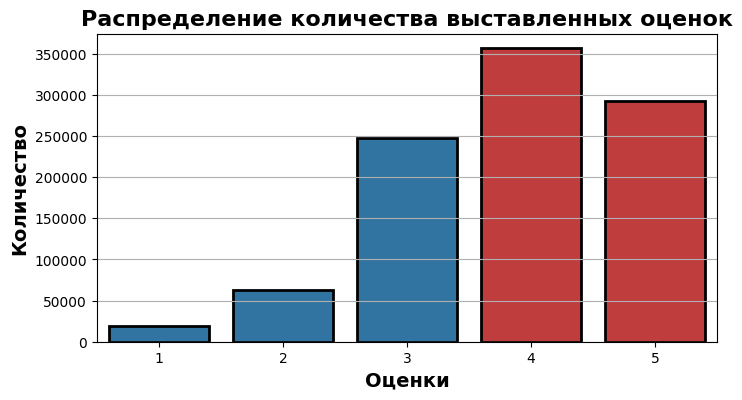

In [11]:
# Countplot в ratings
plt.figure(figsize=(8, 4)) # Размер графика 8 х 6
# Цветовая палитра (1-3 балла: синий, 4-5 баллов: красный)
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red']

# Строим график
sns.countplot(ratings, # Данные из ratings
              x='rating', # Признак с рейтингом
              stat='count', # Считаем количество
              palette=palette, # Палитра
              edgecolor='black', # Цвет границы
              linewidth=2 # Ширина границы
              )

# Настройка подписей
plt.title('Распределение количества выставленных оценок', fontsize=16, fontweight=600)
plt.xlabel('Оценки', fontsize=14, fontweight=600)
plt.ylabel('Количество', fontsize=14, fontweight=600)
plt.grid(axis='y');

,count,mean,std,min,25%,50%,75%,max
ratings_1,5001.0,330.843231,309.058432,11.0,146.0,246.0,414.0,5670.0
ratings_2,5001.0,933.618076,640.852825,30.0,499.0,775.0,1190.0,8233.0
ratings_3,5001.0,3615.196761,1578.823084,323.0,2476.0,3341.0,4481.0,9978.0
ratings_4,5001.0,5696.657868,1788.571229,872.0,4342.0,5509.0,6949.0,9998.0
ratings_5,5001.0,5544.501900,2052.729826,754.0,3950.0,5369.0,7054.0,9999.0


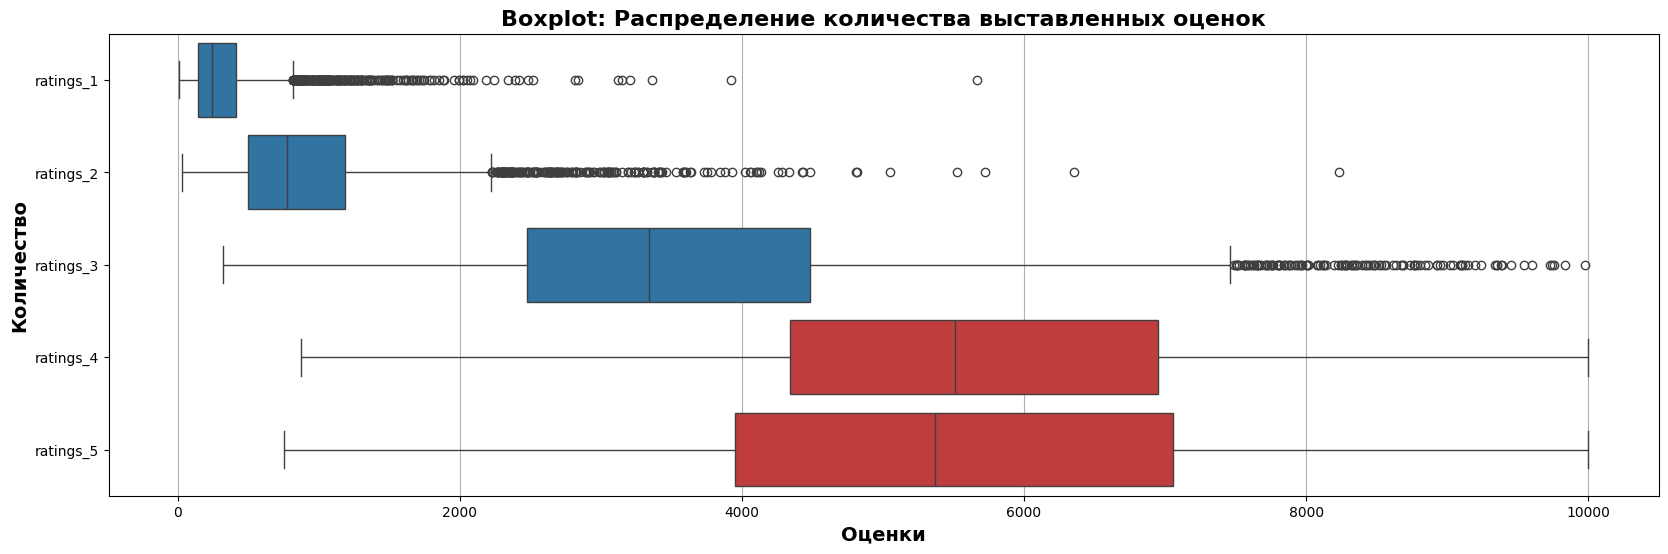

In [12]:
trashhold = 10000 # Задаем ограниение для лучшей визуализации
mask1 = books['ratings_1'] < trashhold # маска для 1 балла
mask2 = books['ratings_2'] < trashhold # маска для 2 баллов
mask3 = books['ratings_3'] < trashhold # маска для 3 баллов
mask4 = books['ratings_4'] < trashhold # маска для 4 баллов
mask5 = books['ratings_5'] < trashhold # маска для 5 баллов
# Формируем датафрейм с признаками количества выставленных оценок
grades = books[mask1 & mask2 & mask3 & mask4 & mask5][['ratings_1','ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']]
# Выводим описательные статистики
display(grades.describe().T)

# Цветовая палитра (1-3 балла: синий, 4-5 баллов: красный)
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red']
plt.figure(figsize=(20, 6)) # Фигура графика 20х6

# Построение boxplot
box = sns.boxplot(
                  grades, # Датафрейм
                  orient='h', # Ориентация по горизонтали
                  palette=palette, # Цветовая палитра                  
                  )

# Настройка подписей
plt.title('Boxplot: Распределение количества выставленных оценок', fontsize=16, fontweight=600)
plt.xlabel('Оценки', fontsize=14, fontweight=600)
plt.ylabel('Количество', fontsize=14, fontweight=600)
plt.grid(axis='x')

*Гипотеза: оценки смещены в пользу высоких баллов*

In [13]:
# Объединяем признаки с низким баллом (1-3)
low_rating = np.concatenate([books['ratings_1'], books['ratings_2'], books['ratings_3']]) 
# Объединяем признаки с высоким баллом (4-5)
high_rating = np.concatenate([books['ratings_4'], books['ratings_5']])

# Проверка распределения на нормальность
H0 = 'Распределение нормальное'
H1 = 'Распределение не является нормальным'
alpha = 0.05 # Уровень значимости

def get_anderson_result(stat: float, critical: float) -> str:
    """Функция возвращает результат
    проверки статистической гипотезы
    по тесту Андерсона-Дарлинга"""
    if stat > critical:
        return H1
    return H0 

def get_mannwhitney_result(p_value: float, alpha: float) -> str: 
    """Функция возвращает результат
    проверки статистической гипотезы
    по тесту Манн-Уитни"""
    if p_value < alpha:
        return H1
    return H0 

# Тест Андерсона-Дарлинга
print('Низкие оценки: 1-3')
result = stats.anderson(low_rating, dist='norm')
stat, critical = result.statistic, result.critical_values
print(f'''Тест Андерсона-Дарлинга: статистика = {stat}\n критические значения: {critical}\n уровни значимости: {result.significance_level} \n 
      alpha={alpha} \n stat > critical 5%: {stat > critical[2]} \n{get_anderson_result(stat, critical[2])}\n''')

print('Высокие оценки: 4-5')
result = stats.anderson(high_rating, dist='norm')
stat, critical = result.statistic, result.critical_values
print(f'''Тест Андерсона-Дарлинга: статистика = {stat}\n критические значения: {critical}\n уровни значимости: {result.significance_level} \n 
      alpha={alpha} \n stat > critical 5%: {stat > critical[2]} \n{get_anderson_result(stat, critical[2])}\n''')

# Тест Манна-Уитни на сравнение двух независимых выборок
H0 = 'Нет статистически значимых различий'
H1 = 'Выборки различаются'

stat, p_value = stats.mannwhitneyu(low_rating, high_rating)
print(f'Тест Манна-Уитни: p-value={round(p_value, 6)}\n alpha={alpha} \n p-value < alpha: {p_value < alpha} \n{get_mannwhitney_result(p_value, alpha)}\n')

Низкие оценки: 1-3
Тест Андерсона-Дарлинга: статистика = 6837.158530515175
 критические значения: [0.576 0.656 0.787 0.918 1.092]
 уровни значимости: [15.  10.   5.   2.5  1. ] 
 
      alpha=0.05 
 stat > critical 5%: True 
Распределение не является нормальным

Высокие оценки: 4-5
Тест Андерсона-Дарлинга: статистика = 4718.864663165776
 критические значения: [0.576 0.656 0.787 0.918 1.092]
 уровни значимости: [15.  10.   5.   2.5  1. ] 
 
      alpha=0.05 
 stat > critical 5%: True 
Распределение не является нормальным

Тест Манна-Уитни: p-value=0.0
 alpha=0.05 
 p-value < alpha: True 
Выборки различаются



**Вывод:** Подтверждаем гипотезу о сильном смещении в пользу высоких оценок. Поведение пользователей, выставляющих высокие и низкие баллы отличается.Пользователи чаще и активнее оценивают книги, которым они ставят высокие баллы (4 и 5). Низкие оценки (1–3) ставятся реже, и их распределение сильно смещено — это указывает на то, что "плохие" книги либо не оцениваются вообще, либо оцениваются только эмоционально раздраженными пользователями.

Высокие оценки представлены гораздо чаще - это может привести к тому, что модель сосредоточится на книгах с высокими оценками и будет игнорировать книги с низкими оценками.

### **Анализ активности пользователей**

*Гипотеза: большинство пользователей выставляют небольшое количество оценок*

,count,mean,std,min,25%,50%,75%,max
rating,53424.0,18.334045,26.224647,1.0,3.0,8.0,22.0,200.0


Общее количество пользователей: 53424
Количество без оценок (0 оценок): 0
Количество неактивных пользователей (1-8 оценок): 27409
Количество пользователей со средним количеством оценок (18 оценок): 725
Количество активных пользователей (больше 50 оценок): 4767 

Доля неактивных пользователей в данных: 51.3%
Доля активных пользователей в данных: 8.92%


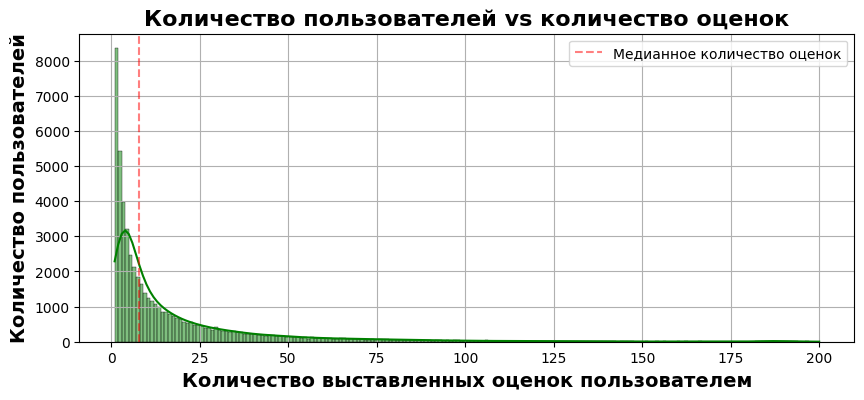

In [14]:
# Подсчет общего количества оценок для каждого пользователя
user_rating = ratings.groupby(by='user_id', as_index=False)['rating'].count()
not_active = user_rating[user_rating['rating'] <= 8] # Неактивные пользователи (1-8 оценок) Медиана - 8
user_mean = user_rating[user_rating['rating'] == 18] # Пользователи со средним количеством оценок
user_0 = user_rating[user_rating['rating'] == 0] # Пользователи не поставившие оценок
active = user_rating[user_rating['rating'] > 50] # Активные пользователи (обльше 50 оценок)

# Вывод информации об активности пользователей
display(user_rating.describe().T[1:])
print(f'Общее количество пользователей: {user_rating.shape[0]}')
print(f'Количество без оценок (0 оценок): {user_0.shape[0]}')
print(f'Количество неактивных пользователей (1-8 оценок): {not_active.shape[0]}')
print(f'Количество пользователей со средним количеством оценок (18 оценок): {user_mean.shape[0]}')
print(f'Количество активных пользователей (больше 50 оценок): {active.shape[0]} \n')
print(f'Доля неактивных пользователей в данных: {round((not_active.shape[0] / user_rating.shape[0]) * 100, 2)}%')
print(f'Доля активных пользователей в данных: {round((active.shape[0] / user_rating.shape[0]) * 100, 2)}%')

# Построение графика
plt.figure(figsize=(10, 4))
hist = sns.histplot(
                    user_rating, # Dataframe
                    x='rating', # Количество выставленных оценок пользователем
                    kde=True, # График плотности
                    color='green' # Цвет                     
                    )
# Линия медианы количества оценок
plt.axvline(user_rating['rating'].median(), color='red', alpha=0.5, linestyle='dashed', label='Медианное количество оценок')

# Настройка подписей
plt.title('Количество пользователей vs количество оценок', fontsize=16, fontweight=600)
plt.xlabel('Количество выставленных оценок пользователем', fontsize=14, fontweight=600)
plt.ylabel('Количество пользователей', fontsize=14, fontweight=600)
plt.legend()
plt.grid()

In [15]:
# Коэффициент асимметрии
print(f'Коэффициент асимметрии: {user_rating["rating"].skew()}')

Коэффициент асимметрии: 3.144117946413108


Распределение количества оценок на пользователя — сильно скошено вправо, что характерно для рекомендательных систем. Более половины пользователей  — неактивные (1–8 оценок): проблема холодного старта — для них сложно строить персонализированные рекомендации, так как данных слишком мало.

Активных пользователей — относительно немного, но они генерируют значительную часть всех оценок.

In [16]:
# Проверка распределения на нормальность
H0 = 'Распределение нормальное'
H1 = 'Распределение не является нормальным'
alpha = 0.05 # Уровень значимости

# Тест Андерсона-Дарлинга
print('Низкая активность')
result = stats.anderson(not_active['rating'], dist='norm')
stat, critical = result.statistic, result.critical_values
print(f'''Тест Андерсона-Дарлинга: статистика = {stat}\n критические значения: {critical}\n уровни значимости: {result.significance_level} \n 
      alpha={alpha} \n stat > critical 5%: {stat > critical[2]} \n{get_anderson_result(stat, critical[2])}\n''')

print('Высокая активность')
result = stats.anderson(active['rating'], dist='norm')
stat, critical = result.statistic, result.critical_values
print(f'''Тест Андерсона-Дарлинга: статистика = {stat}\n критические значения: {critical}\n уровни значимости: {result.significance_level} \n 
      alpha={alpha} \n stat > critical 5%: {stat > critical[2]} \n{get_anderson_result(stat, critical[2])}\n''')

# Тест Манна-Уитни на сравнение двух независимых выборок
H0 = 'Нет статистически значимых различий'
H1 = 'Выборки различаются'

stat, p_value = stats.mannwhitneyu(not_active['rating'], active['rating'])
print(f'Тест Манна-Уитни: p-value={round(p_value, 6)}\n alpha={alpha} \n p-value < alpha: {p_value < alpha} \n{get_mannwhitney_result(p_value, alpha)}\n')

Низкая активность
Тест Андерсона-Дарлинга: статистика = 1188.2421069595075
 критические значения: [0.576 0.656 0.787 0.918 1.092]
 уровни значимости: [15.  10.   5.   2.5  1. ] 
 
      alpha=0.05 
 stat > critical 5%: True 
Распределение не является нормальным

Высокая активность
Тест Андерсона-Дарлинга: статистика = 257.3921962306049
 критические значения: [0.576 0.655 0.786 0.917 1.091]
 уровни значимости: [15.  10.   5.   2.5  1. ] 
 
      alpha=0.05 
 stat > critical 5%: True 
Распределение не является нормальным

Тест Манна-Уитни: p-value=0.0
 alpha=0.05 
 p-value < alpha: True 
Выборки различаются



**Вывод:**

+ Пользователи с низкой и высокой активностью принадлежат к разным распределениям — их поведение принципиально отличается.

+ Проблема холодного старта выражена сильно — более 50% пользователей имеют < 9 оценок.

### **Анализ популярности книг.**

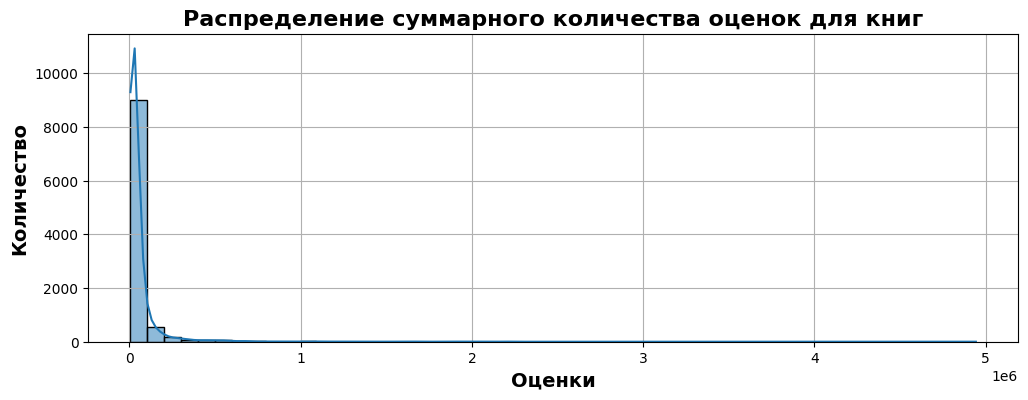

In [17]:
# Гистограмма распределения значений в work_ratings_count
plt.figure(figsize=(12, 4))
hist = sns.histplot(books,
                    x='work_ratings_count',
                    bins=50,
                    kde=True)

# Настройка подписей
plt.title('Распределение суммарного количества оценок для книг', fontsize=16, fontweight=600)
plt.xlabel('Оценки', fontsize=14, fontweight=600)
plt.ylabel('Количество', fontsize=14, fontweight=600)
plt.grid()

In [18]:
print(f'Коэффициент асимметрии: {books["work_ratings_count"].skew()}')

Коэффициент асимметрии: 12.414521866631116


Сильная правосторонняя асимметрия

In [19]:
# Статистики по количеству оценок
print(f'Минимальное количество оценок для 1 книги: {books["work_ratings_count"].min()}')
print(f'Максимальное количество оценок для 1 книги: {books["work_ratings_count"].max()}')
print(f'Среднеее количество оценок для 1 книги: {books["work_ratings_count"].mean()}')
print(f'Медианное количество оценок для 1 книги: {books["work_ratings_count"].median()}')

# Количество книг с минимальным количеством оценок
books_min = books[books['work_ratings_count'] == books['work_ratings_count'].min()].shape[0]
# Количество книг с низким количеством оценок (min - 20 000)
books_low_grades = books[(books['work_ratings_count'] > books['work_ratings_count'].min()) & (books['work_ratings_count'] <= 20000)].shape[0]
# Количество книг со средним количеством оценок (20 000 - 100 000)
books_avg_grades = books[(books['work_ratings_count'] > 20000) & (books['work_ratings_count'] <= 100000)].shape[0]
# Количество книг с высоким количеством оценок (100 000 - 1 000 000)
books_high_grades = books[(books['work_ratings_count'] > 100000) & (books['work_ratings_count'] <= 1000000)].shape[0]
# Количество книг количеством оценок больше 1 000 000
books_more_mln_grades = books[(books['work_ratings_count'] > 1000000)].shape[0]

# Процентное соотношение
books_min_per = round(round(books_low_grades / books.shape[0] * 100, 2) / books.shape[0] * 100, 2)
books_low_grades_per = round(books_low_grades / books.shape[0] * 100, 2)
books_avg_grades_per = round(books_avg_grades / books.shape[0] * 100, 2)
books_high_grades_per = round(books_high_grades / books.shape[0] * 100, 2)
books_more_mln_grades_per = round(round(books_high_grades / books.shape[0] * 100, 2) / books.shape[0] * 100, 2)

print()
print(f'Количество книг с минимальным количеством оценок: {books_min}')
print(f'Количество книг с низким количеством оценок (min - 20 000): {books_low_grades}')
print(f'Количество книг со средним количеством оценок (20 000 - 100 000): {books_avg_grades}')
print(f'Количество книг с высоким количеством оценок (100 000 - 1 000 000): {books_high_grades}')
print(f'Количество книг количеством оценок больше 1 000 000: {books_more_mln_grades}\n')

print(f'Доля книг с минимальным количеством оценок: {books_min_per} %')
print(f'Доля книг с низким количеством оценок (min - 20 000): {books_low_grades_per} %')
print(f'Доля книг со средним количеством оценок (20 000 - 100 000): {books_avg_grades_per} %')
print(f'Доля книг с высоким количеством оценок (100 000 - 1 000 000): {books_high_grades_per} %')
print(f'Доля книг количеством оценок больше 1 000 000: {books_more_mln_grades_per} %')

Минимальное количество оценок для 1 книги: 5510
Максимальное количество оценок для 1 книги: 4942365
Среднеее количество оценок для 1 книги: 59687.3216
Медианное количество оценок для 1 книги: 23832.5

Количество книг с минимальным количеством оценок: 1
Количество книг с низким количеством оценок (min - 20 000): 4065
Количество книг со средним количеством оценок (20 000 - 100 000): 4885
Количество книг с высоким количеством оценок (100 000 - 1 000 000): 989
Количество книг количеством оценок больше 1 000 000: 60

Доля книг с минимальным количеством оценок: 0.41 %
Доля книг с низким количеством оценок (min - 20 000): 40.65 %
Доля книг со средним количеством оценок (20 000 - 100 000): 48.85 %
Доля книг с высоким количеством оценок (100 000 - 1 000 000): 9.89 %
Доля книг количеством оценок больше 1 000 000: 0.1 %


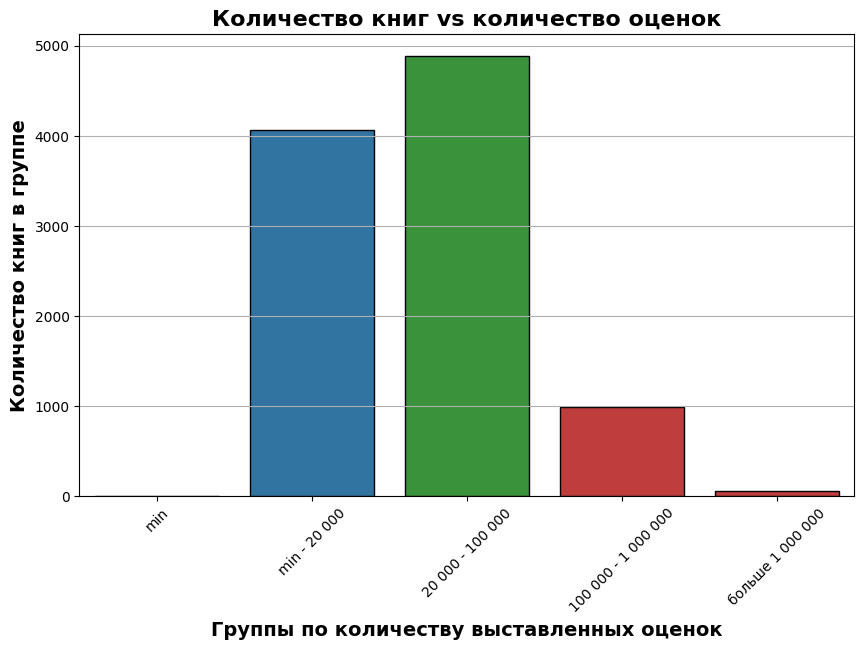

In [20]:
# датафрейм со сгруппированным количеством оценок
book_grade_count = pd.DataFrame(
                    {'min' : [books_min],
                    'min - 20 000': [books_low_grades],
                    '20 000 - 100 000': [books_avg_grades],
                    '100 000 - 1 000 000': [books_high_grades],
                    'больше 1 000 000': [books_more_mln_grades]},
                    )

# Палитра: синий - низкое количесвто оценок
# зеленый - среднее количество оценок
# красный - высокое количесвто оценок
palette = ['tab:blue','tab:blue', 'tab:green', 'tab:red', 'tab:red']
plt.figure(figsize=(10, 6))
bar = sns.barplot(
                  book_grade_count, # Данные
                  palette=palette, # Цветоваля палитра
                  edgecolor='black' # Цвет границы
                  )

# Настройка подписей
plt.title('Количество книг vs количество оценок', fontsize=16, fontweight=600)
plt.xlabel('Группы по количеству выставленных оценок', fontsize=14, fontweight=600)
plt.ylabel('Количество книг в группе', fontsize=14, fontweight=600)
plt.xticks(rotation=45)
plt.grid(axis='y')

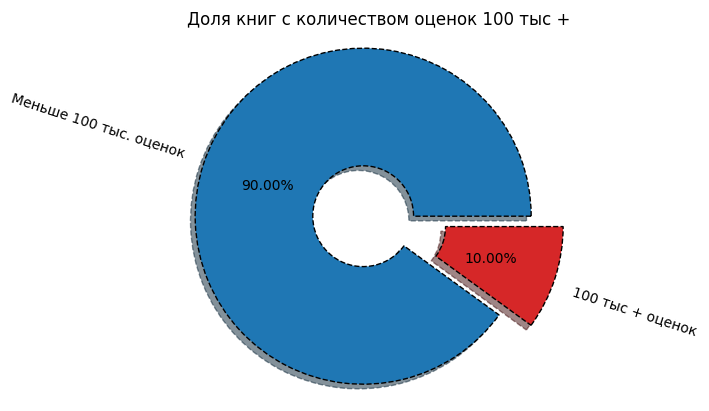

In [21]:
# Массив значений процентов для оценок с границей в 100 тыс
book_grade_per = np.array([books_min_per + books_low_grades_per + books_avg_grades_per,
                          books_high_grades_per + books_more_mln_grades_per])  
labels = ['Меньше 100 тыс. оценок', '100 тыс + оценок'] # Метки   
explode = (0, 0.2) # Выход сегмента из графика
colors = ['tab:blue', 'tab:red'] # Цвета

fig, ax = plt.subplots()
ax.pie(book_grade_per, # Данные
       labels=labels, # Метки
       colors=colors, # Цветовая палитра
       autopct='%1.2f%%', # формат числа величины доли внутри сегмента 
       shadow=True, # с тенью
       explode=explode, # список долей, выносимых из диаграммы
       rotatelabels=True, # поворачиваем подписи
       wedgeprops=dict(width=0.7, linestyle='--', edgecolor='k')) # Настройка границы

# Настройка названия
ax.set_title('Доля книг с количеством оценок 100 тыс +')
ax.axis('equal');

,authors,original_title,work_ratings_count
0,Suzanne Collins,The Hunger Games,4942365
1,"J.K. Rowling, Mary GrandPré",Harry Potter and the Philosopher's Stone,4800065
2,Stephenie Meyer,Twilight,3916824
3,Harper Lee,To Kill a Mockingbird,3340896
4,F. Scott Fitzgerald,The Great Gatsby,2773745
5,John Green,The Fault in Our Stars,2478609
11,Veronica Roth,Divergent,2216814
6,J.R.R. Tolkien,The Hobbit or There and Back Again,2196809
9,Jane Austen,Pride and Prejudice,2191465
7,J.D. Salinger,The Catcher in the Rye,2120637


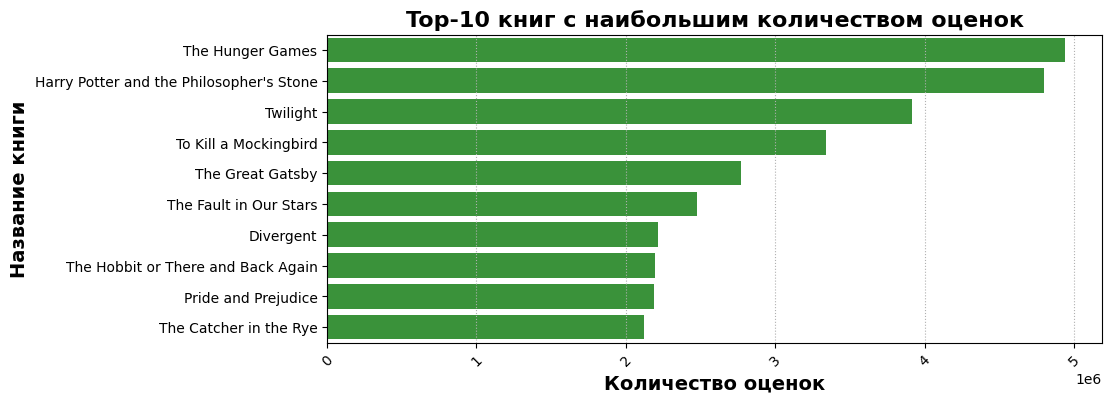

In [22]:
# Top-10 популярных книг
# Отфильтровываем книги, у которых больше 1 млн оценок
# Сортируем по убыванию количества оценок
# Отфильтровываем признаки 'original_title', 'work_ratings_count'
# Берем 10 первых строк
top_10_books = books[(books['work_ratings_count'] > 1000000)].sort_values(by='work_ratings_count', ascending=False)[['authors', 'original_title', 'work_ratings_count']].head(10)
display(top_10_books)

# Построение графика
plt.figure(figsize=(10, 4))
bar = sns.barplot(
                  top_10_books, # Данные
                  x='work_ratings_count', # Количество оценок
                  y='original_title', # Название книги
                  color='tab:green' # Цвет
                  )

# Настройка подписей
plt.title('Top-10 книг с наибольшим количеством оценок', fontsize=16, fontweight=600)
plt.xlabel('Количество оценок', fontsize=14, fontweight=600)
plt.ylabel('Название книги', fontsize=14, fontweight=600)
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='dotted')

Распределение очень сильно смещено вправо — медиана (23 832) почти в 2.5 раза меньше среднего (59 687), что указывает на наличие высоких выбросов (популярных книг).

90% всех книг  имеют менее 100 000 оценок - это "длинный хвост". Только 0.1% получили более 1 миллиона оценок - это популярные хиты.

Все топ-10 — мировые бестселлеры, многие из них — юношеская литература или классика.

Это «звезды» каталога — они привлекают основную массу оценок, но не отражают вкусов всей аудитории.

### **Анализ тегов**

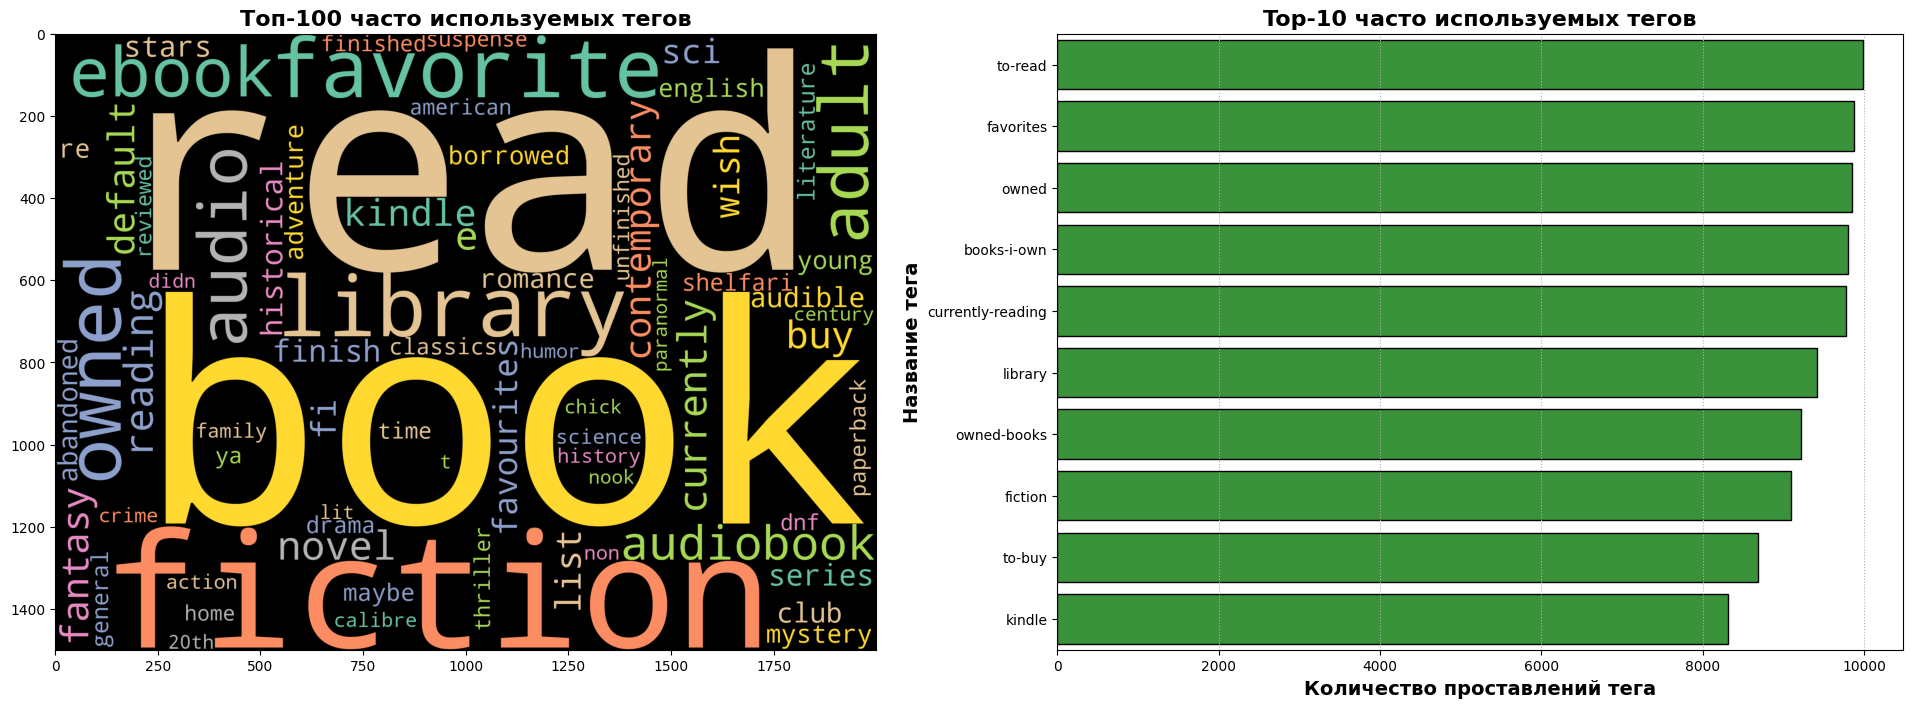

In [23]:
# Выделяем 100 тегов с наибольшим количеством упоминаний
book_tags_id_top_100 = book_tags['tag_id'].value_counts().nlargest(100)
# Соединяем датафреймы по tag_id
tags_top_100 = pd.merge(book_tags_id_top_100, tags, on='tag_id', how='left')
# Создаем строку, где каждый тег повторяется столько раз, 
# сколько упоминается для топ-100 книг
tags_top_100_string = ' '.join(((tags_top_100['tag_name'] + ' ') * tags_top_100['count']).to_list())

# Построение визуализаций
fig, axes = plt.subplots(1, 2, figsize =(24, 8))
# WordCloud
word_cloud = WordCloud(
                      width=2000, # Ширина
                      height=1500, # Высота
                      max_words=100, # максимальное количество слов
                      background_color='black', # Цвет фона
                      colormap='Set2', # Палитра
                      collocations=False # Повторения
                      ).generate(tags_top_100_string) # Генерация wordcloud

axes[0].imshow(word_cloud.to_image()) # Отображение wordcloud
axes[0].set_title('Топ-100 часто используемых тегов', fontsize=16, fontweight=600) # Название графика

bar = sns.barplot(tags_top_100[:10], # Выбираем первые 10 строк
                  y='tag_name', # Название тега по оси у
                  x='count', # Количество упоминаний по оси х
                  color='tab:green', # Цвет столбцов
                  edgecolor='black', # Цвет границы
                  orient='h', # Ориентация горизонтальная
                  ax=axes[1] # Подграфик
                  )

bar.set_title('Top-10 часто используемых тегов', fontsize=16, fontweight=600)
bar.set_xlabel('Количество проставлений тега', fontsize=14, fontweight=600)
bar.set_ylabel('Название тега', fontsize=14, fontweight=600)
bar.grid(axis='x', linestyle='dotted')

+ Пользователи активно используют теги, связанные с управлением своей библиотекой:

«Что я хочу прочитать», «Что я уже прочитал», «Что у меня есть» — это основа поведения пользователей. Это указывает на то, что приложение работает как личная библиотека + планировщик чтения, а не только как платформа для оценок.

+ Жанровая классификация вторична

Жанр "fiction" — единственный жанровый тег в топ-10. Это говорит о том, что пользователи чаще метят книги по статусу чтения, а не по жанру или формату.

+ Пользователи используют теги для выражения эмоций ("didn't like", "maybe"), семейного контекста ("family"), оценки качества ("stars").

**Вывод:** EDA позволяет выявить ключевые проблемы, которые могут негативно повлиять на качество рекомендаций.

+ Разреженность: большинство пользователей оценили только малую часть книг. Взаимодействий между пользователями и книгами — мало, по сравнению с возможным количеством.
+ Смещение популярности: малое количество "популярных" книг получает большинство оценок
+ Смещение по статусу чтения: пользователи чаще оценивают книги, которые им понравились, или не оценивают вовсе


In [24]:
# Словарь для записи метрик
metrics_dict = {
    'Popularity model' : {'Precision@k' : None, 'Recall@k' : None, 'nDCG@k' : None},
    'Content based' : {'Precision@k' : None, 'Recall@k' : None, 'nDCG@k' : None},
    'Collaborative Filtering' : {'Precision@k' : None, 'Recall@k' : None, 'nDCG@k' : None},
    'SVD model' : {'Precision@k' : None, 'Recall@k' : None, 'nDCG@k' : None},
}

# <center> **Этап 2: базовые и контентные модели**

### **1. Populatity Recommendation model**

Алгоритм, возвращающий Top-k самых популярных книг (по среднему рейтингу с порогом минимального количества оценок).

In [25]:
# Создаем датафрейм для рекомендации по популярности
populatity_data = books[['authors', 'original_title', 'average_rating', 'work_ratings_count']]
# Отфильтруем все книги, средний рейтинг которых больше 4
populatity_data = populatity_data[populatity_data['average_rating'] > 4].reset_index(drop=True)
# Проверим пропущенные значения
populatity_data.isnull().mean()*100

authors               0.000000
original_title        6.766917
average_rating        0.000000
work_ratings_count    0.000000
dtype: float64

Присутствуют пропущенные значения в признаках original_title 16 % 

In [26]:
# Отфильтруем пропущенные значения
populatity_data_null = populatity_data[pd.isnull(populatity_data['original_title'])]

# Количество книг с средним рейтингом > 4
print(f'Количество книг с рейтингом больше 4.5: {populatity_data[populatity_data["average_rating"] > 4].shape[0]}')

# Проверим есть ли среди них книги с рейтингом выше 4 пропущенные значения
populatity_data_null[populatity_data_null['average_rating'] > 4]

Количество книг с рейтингом больше 4.5: 5187


,authors,original_title,average_rating,work_ratings_count
80,Anthony Doerr,NaN,4.308594,547827
124,Richelle Mead,NaN,4.140625,455151
126,Ernest Cline,NaN,4.308594,421819
145,"Jane Carruth, Lewis Carroll, Rene Cloke",NaN,4.031250,343271
170,"Todd Burpo, Lynn Vincent",NaN,4.011719,243018
...,...,...,...,...
5152,Shauna Niequist,NaN,4.218750,9178
5156,Steven Johnson,NaN,4.031250,8565
5160,"Malvina G. Vogel, Arthur Conan Doyle",NaN,4.488281,9861
5162,R.K. Lilley,NaN,4.460938,18709


Пропуски могли появиться при ошибке записи данных. У 21 книги из 129 пропущен ключевой признак - название. ~100 книг может быть достаточно для рекомендации по популярности. Удалим строки с пропусками.

In [27]:
# Удаляем строки с пропусками
populatity_data = populatity_data.dropna()
populatity_data = populatity_data.reset_index(drop=True)
print(f'Количество книг с рейтингом больше 4: {populatity_data[populatity_data["average_rating"] > 4].shape[0]}')
# Количество пропущенных значений
print(f'Количество пропущенных значений: {populatity_data.isnull().sum()}')
print(f'Есть ли в выборке книги со средним рейтингом <= 4: {bool(populatity_data[populatity_data["average_rating"] <= 4].shape[0])}')

Количество книг с рейтингом больше 4: 4836
Количество пропущенных значений: authors               0
original_title        0
average_rating        0
work_ratings_count    0
dtype: int64
Есть ли в выборке книги со средним рейтингом <= 4: False


In [28]:
class PopularityRecommender():
    """Модель рекомендаций Топ-k популярных книг
    с порогом по количеству оценок"""
    # Конструктор класса
    def __init__(self, k: int, treshold: int = int(populatity_data['work_ratings_count'].mean())):        
        self.k = k # Количество записей в рекомендациях
        self.treshold = treshold # Порог количества оценок (по умолчанию - среднее значение)
        self.train = None # Датафрейм для обучения
        self.valid = 0 # Счетчик количества релевантных рекомендаций
    
    #  Метод для обучения модели
    def fit(self, data: pd.DataFrame):
        """Метод передает выбоку данных для обучения в класс"""
        self.train = data
    
    # Метод для рекомендаций 
    def recommend(self) -> pd.DataFrame:
        """Метод возвращаете Топ-k рекомендованных книг по популярности
        с добавлением случайности выбора"""
        # фильтруем данные по порогу количества оценок
        filtered_train = self.train[self.train['work_ratings_count'] > self.treshold]        
        # Формируем случайную выборку из k книг
        # и сортируем по убыванию среднего рейтинга
        sample_k = filtered_train.sample(self.k).sort_values('average_rating', ascending=False)        
        return sample_k[['authors',	'original_title', 'average_rating']]
    
    # Точность при K рекомендациях
    def precision_k(self, relevance: int = 4) -> float:
        """Метод возвращает метрику precision@k:
        количество релевантных элементов в top-k /
        количество k элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.valid = 0 # Обнуляем счетчик, чтобы не накапливался
        # Берем из рекомендаций признак среднего рейтинга        
        ratings = self.recommend()['average_rating']
        # Проверяем сколько из них больше порога релевантности
        for rating in ratings.values:
            if rating > relevance:
                self.valid += 1
        # Считаем метрику
        return self.valid / self.k
        
    # Полнота при K рекомендациях
    def recall_k(self, relevance: int = 4) -> float:
        """Метод возвращает метрику recall@k:
        количество релевантных элементов в top-k /
        общее количество релевантных элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.precision_k(relevance)
        # Считаем общее количество книг с релевантным рейтингом
        relevant_books = books[books['average_rating'] > relevance].shape[0]
        # Считаем метрику: релевантные в рекомендации / общее количество релевантных
        return self.valid / relevant_books  
     
    # Метод для определения ранга рекомендации
    @staticmethod
    def get_relevance_list(ratings: list) -> list:
        """Метод назначает вес рангу релевантности
            для среднего рейтинга > 4.6 -> 4
            для среднего рейтинга от 4.4 до 4.6 -> 3
            для среднего рейтинга от 4.2 до 4.4 -> 2
            для среднего рейтинга от 4 до 4.2 -> 1
            для среднего рейтинга ниже 4 -> 0
        """
        relevance_list = [] # Список весов релевантности
        for rating in ratings:
            if rating >= 4.6:
                relevance_list.append(4)
            elif 4.4 <= rating < 4.6:
                relevance_list.append(3)
            elif 4.2 <= rating < 4.4:
                relevance_list.append(2)
            elif 4.0 <= rating < 4.2:
                relevance_list.append(1)
            else:
                relevance_list.append(0)
        if relevance_list:
            return relevance_list
        return f'Список релевантности пуст'
    
    # Normalized Discounted Cumulative Gain
    def ndcg_k(self) -> float:
        """Метод возвращаетм метрику nDCG@k:
        ранжированная метрика, которая учитывает порядок
        рекомендованных элементов и их релевантность""" 
        # Получаем список рейтингов рекомендованных элементов
        ratings = self.recommend()['average_rating'].tolist()
        # Получаем список релевантностей
        relevance_list = self.get_relevance_list(ratings)
        # Считаем DSG@k: sum(rel_i / log2(i + 1))
        dcg_k = sum([(relevance_list[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list) + 1)])
        # Считаем IDSG@k: sum(rel_i / log2(i + 1)) по отсортированному списку
        relevance_list_sorted = sorted(relevance_list, reverse=True) # Сортируем список по убыванию
        idcg_k = sum([(relevance_list_sorted[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list_sorted) + 1)])
        # Считаем nDCG@k: DSG@k / IDSG@k
        return dcg_k / idcg_k

In [29]:
%time
# Объект класса PopularityRecommender
popularity_rec = PopularityRecommender(k=10)
popularity_rec.fit(populatity_data) # Обучение модели

# Вывод информации
print('='*20, 'Метрики', '='*25)
print(f'Precision@k: {popularity_rec.precision_k()}')
print(f'Recall@k: {popularity_rec.recall_k()}')
print(f'nDCG@k: {popularity_rec.ndcg_k()}')

print('='*20, 'Рекомендации', '='*20)
print(f'Top-{popularity_rec.k} книг')
popularity_rec.recommend()

CPU times: total: 0 ns
Wall time: 0 ns
==================== Метрики =========================
Precision@k: 1.0
Recall@k: 0.00192789666473877
nDCG@k: 1.0
==================== Рекомендации ====================
Top-10 книг


,authors,original_title,average_rating
410,Arthur Conan Doyle,The Complete Sherlock Holmes,4.500000
109,"Alan Moore, Dave Gibbons, John Higgins",Watchmen,4.351562
451,"Paul Kalanithi, Abraham Verghese",When Breath Becomes Air,4.320312
1121,Elle Kennedy,The Deal,4.300781
764,Tamora Pierce,Alanna: The First Adventure,4.269531
662,"Harry Allard, James Marshall",Miss Nelson Is Missing!,4.261719
776,Laini Taylor,Days of Blood & Starlight,4.210938
761,Helene Wecker,The Golem and the Jinni,4.101562
365,"Robert Galbraith, J.K. Rowling",The Silkworm,4.031250
230,Thomas Harris,Red Dragon,4.011719


In [30]:
# Добавление метрик в словарь
metrics_dict['Popularity model']['Precision@k'] = popularity_rec.precision_k()
metrics_dict['Popularity model']['Recall@k'] = popularity_rec.recall_k()
metrics_dict['Popularity model']['nDCG@k'] = popularity_rec.ndcg_k()

**Выводы**
1. Precision@K = 1.0
    + Все 10 книг — релевантные (рейтинг > 4).
    + Это показывает, что модель "не ошибается" в рекомендациях.
2. Модель не охватывает релевантные книги (Recall@K = 0.0019)
    + В датасете очень много книг с рейтингом > 4.
    + Модель рекомендует только 0,19 %, но игнорирует остальные.
    + Это указывает на смещение в сторону популярности (popularity bias).
3. Порядок рекомендованных книг оптимален (nDCG@K = 1.0)
    + Книги отсортированы по убыванию рейтинга.


### **2. Контентная модель**

+ Объедините данные о книгах с их тегами. Для каждой книги создайте текстовый «профиль» из названия (original_title) и списка тегов.
+ Векторизуйте эти профили с помощью TF-IDF.
+ Реализуйте функцию get_similar_books(book_id, k=5), которая находит k самых похожих книг по косинусной мере близости между их TF-IDF-векторами.

In [31]:
class ContentRecommender():
    """Класс реализует контентную рекомендательную модель.
    По id книги рекомендует k книг по косинусному расстоянию"""    
    def __init__(self):        
        self.books = None # Датафрейм с информацией о книгах
        self.book_tags = None # Датафрейм соответствия книг и тегов
        self.tags = None # Датафрейм тегов         
        self.book_vectors = None # Словарь book_id: tf-idf-вектор
        self.k = 5 # Количество книг для рекомендации        
        self.valid = 0 # Счетчик количества релевантных рекомендаций
        
    #  Метод для обучения модели
    def fit(self, books: pd.DataFrame, book_tags: pd.DataFrame, tags: pd.DataFrame):
        """Метод передает выбоку данных для обучения в класс"""
        books = books.dropna(subset='original_title')
        self.books = books
        self.book_tags = book_tags
        self.tags = tags
        self.book_vectors = self.TFiDFVectorizer()
        
    # Метод создает профиль книги с тегами
    def transform(self) -> pd.Series:
        """Метод преобразует данные из book_tags и tags.
        Возвращает pd.Series с book_id в индексе
        и множеством имен тегов в значении"""
        # Объединяем book_tags с tags
        book_tags_with_names = self.book_tags.merge(
            self.tags[['tag_id', 'tag_name']], on='tag_id', how='left'
        )
        # Группируем по goodreads_book_id
        book_to_tag_names = book_tags_with_names.groupby('goodreads_book_id', as_index=False)['tag_name'].apply(set)
        # Объединяем нзвания книг и присвенные теги
        # Отфильтровываем 'book_id' и 'title' из books
        # Объединяем с названиями тегов
        books_and_tags = self.books[['book_id', 'title']].merge(
                                                        book_to_tag_names, # Группируем с именами тегов
                                                        left_on='book_id', # Группировка по id слева
                                                        right_on='goodreads_book_id', # Группировка по id справа
                                                        how='left' # Тип группировки по левому датафрейму
                                                           )
        # Убираем дублирующисй признак с id
        books_and_tags = books_and_tags.drop('goodreads_book_id', axis=1)
        # Переводим id книги в индекс
        books_and_tags = books_and_tags.set_index('book_id')
        return books_and_tags
    
    # Метод для векторизации тегов в профиле книги
    def TFiDFVectorizer(self) -> dict:
        """Метод производит TF-IDF векторизацию для всех тегов.        
        Заменяет имена тега в профиле на вектор индексов if-idf"""
        books_and_tags = self.transform()
        # Лемматизатор для тегов
        lemmatizer = WordNetLemmatizer()
        # Преобразуем множество тегов в строки
        # Каждый тег в множестве приводим к нижнему регистру и убираем пробелы
        # К тегу применяем лемматизатор и соединяем теги в строку
        books_and_tags['tag_string'] = books_and_tags['tag_name'].apply(
            lambda tag_set: ' '.join([lemmatizer.lemmatize(tag.lower().strip()) for tag in tag_set])
        )
        # Объект TF-IDF векторизатора
        vectorizer = TfidfVectorizer()
        # Обучаем TF-IDF на всех строках тегов и получаем матрицу
        tfidf_matrix = vectorizer.fit_transform(books_and_tags['tag_string'])          
        # Проходим циклом по id книг
        book_vectors = {} # Словарь book_id: tf-idf-вектор
        for index, book_id in enumerate(books_and_tags.index):
            # book_id - ключ словаря, значение - tf-idf книги преобразованные в одномерный массив
            book_vectors[book_id] = tfidf_matrix[index].toarray().flatten()
        return book_vectors
        
    # Метрика близости
    @staticmethod
    def cosine_distance(v1: np.array, v2: np.array) -> float:
        """Метод рассчитывает косинусное расстояние
        между двумф векторами: 1 - (v1 * v2) / (||v1|| * ||v2||)"""        
        dot_product = np.dot(v1, v2) # Скалярное произведение векторов  
        norm_v1, norm_v2 = np.linalg.norm(v1), np.linalg.norm(v2) # Длины векторов        
        similarity = dot_product / (norm_v1 * norm_v2) # Косинусное сходство: (v1 * v2) / (||v1|| * ||v2||)        
        return 1 - similarity # Косинусное расстояние: 1 - similarity
    
    # Метод для выдачи рекомендации
    def recommend(self, book_id: int, k: int = 5) -> pd.DataFrame:
        """Метод возвращает рекоммендацию из k (по умолчанию - 5)
        наиболее близких по косинусному расстоянию книг
        по введенному id книги""" 
        if book_id not in self.book_vectors:
            raise KeyError(f"Book ID {book_id} отсутствует в словаре векторов")       
        self.k = k        
        distances = {} # Словарь для сохранения индекса книги и расстояния
        # Цикл по словарю с векторами       
        for id, v2 in self.book_vectors.items():
            # Считаем расстояние для book_id с каждой книгой
            distance = self.cosine_distance(self.book_vectors[book_id], v2)           
            # Если расстояние не равно 0 (расстояние книги с собой)
            if distance > 1e-9: # Вместо 0 используем маленькое значение, чтобы избежать погрешности
                distances[id] = distance # Записываем id и расстояние в словарь  
        # Получаем список id книг
        # Сортируем значения словаря по возрастанию
        # Создаем список и берем первые k элементов
        recommended_books = list(dict(sorted(distances.items(), key=lambda item: item[1])).keys())[:self.k]
        # Выбираем признаки для отображения
        books_recs = self.books[['book_id', 'authors', 'original_title', 'average_rating']].set_index('book_id')        
        return books_recs.loc[recommended_books]
    
    # Точность при K рекомендациях
    def precision_k(self, book_id: int, relevance: int = 4) -> float:
        """Метод возвращает метрику precision@k:
        количество релевантных элементов в top-k /
        количество k элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.valid = 0 # Обнуляем счетчик, чтобы не накапливался
        # Берем из рекомендаций признак среднего рейтинга        
        ratings = self.recommend(book_id)['average_rating']
        # Проверяем сколько из них больше порога релевантности
        for rating in ratings.values:
            if rating > relevance:
                self.valid += 1
        # Считаем метрику
        return self.valid / self.k
    
    # Полнота при K рекомендациях
    def recall_k(self, book_id: int, relevance: int = 4) -> float:
        """Метод возвращает метрику recall@k:
        количество релевантных элементов в top-k /
        общее количество релевантных элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.precision_k(book_id, relevance)
        # Считаем общее количество книг с релевантным рейтингом
        relevant_books = books[books['average_rating'] > relevance].shape[0]
        # Считаем метрику: релевантные в рекомендации / общее количество релевантных
        return self.valid / relevant_books  
    
    # Метод для определения ранга рекомендации
    @staticmethod
    def get_relevance_list(ratings: list) -> list:
        """Метод назначает вес рангу релевантности
            для среднего рейтинга > 4.6 -> 4
            для среднего рейтинга от 4.4 до 4.6 -> 3
            для среднего рейтинга от 4.2 до 4.4 -> 2
            для среднего рейтинга от 4 до 4.2 -> 1
            для среднего рейтинга ниже 4 -> 0
        """
        relevance_list = [] # Список весов релевантности
        for rating in ratings:
            if rating >= 4.6:
                relevance_list.append(4)
            elif 4.4 <= rating < 4.6:
                relevance_list.append(3)
            elif 4.2 <= rating < 4.4:
                relevance_list.append(2)
            elif 4.0 <= rating < 4.2:
                relevance_list.append(1)
            else:
                relevance_list.append(0)
        if relevance_list:
            return relevance_list
        return f'Список релевантности пуст'
    
     # Normalized Discounted Cumulative Gain
    def ndcg_k(self, book_id: int) -> float:
        """Метод возвращаетм метрику nDCG@k:
        ранжированная метрика, которая учитывает порядок
        рекомендованных элементов и их релевантность""" 
        # Получаем список рейтингов рекомендованных элементов
        ratings = self.recommend(book_id)['average_rating'].tolist()
        # Получаем список релевантностей
        relevance_list = self.get_relevance_list(ratings)
        # Считаем DSG@k: sum(rel_i / log2(i + 1))
        dcg_k = sum([(relevance_list[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list) + 1)])
        # Считаем IDSG@k: sum(rel_i / log2(i + 1)) по отсортированному списку
        relevance_list_sorted = sorted(relevance_list, reverse=True) # Сортируем список по убыванию
        idcg_k = sum([(relevance_list_sorted[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list_sorted) + 1)])
        # Считаем nDCG@k: DSG@k / IDSG@k
        return dcg_k / idcg_k

In [32]:
id = 11870085 # id книги

# Объект класса ContentRecommender
content_rec = ContentRecommender()
start_recommend = time()
content_rec.fit(books, book_tags, tags) # Обучение модели
recommendation = content_rec.recommend(id)
end_recommend = time()
print(f'Время обучения модели: {end_recommend - start_recommend} сек.')

# Вывод информации
authors = books[books['book_id'] == id]['authors']	
title = books[books['book_id'] == id]['original_title']	
rating = books[books['book_id'] == id]['average_rating']	
print('='*20, 'Выбрана книга', '='*20)
print(f'id: {id} \nАвтор: {authors.values[0]} \nНазвание: {title.values[0]} \nСредний рейтинг: {rating.values[0]}\n')

print('='*20, 'Метрики', '='*25)
print(f'Precision@k: {content_rec.precision_k(id)}')
print(f'Recall@k: {content_rec.recall_k(id)}')
print(f'nDCG@k: {content_rec.ndcg_k(id)}')

print('='*20, 'Рекомендации', '='*20)
print(f'Top-{content_rec.k} книг')
display(recommendation)

Время обучения модели: 8.469102144241333 сек.
==================== Выбрана книга ====================
id: 11870085 
Автор: John Green 
Название: The Fault in Our Stars 
Средний рейтинг: 4.26171875

==================== Метрики =========================
Precision@k: 0.6
Recall@k: 0.000578368999421631
nDCG@k: 0.6797310500037655
==================== Рекомендации ====================
Top-5 книг


,authors,original_title,average_rating
book_id,,,
1314332,Jenny Downham,Before I Die,3.839844
11071466,Morgan Matson,Second Chance Summer,4.160156
4374400,Gayle Forman,If I Stay,3.960938
8492825,Gayle Forman,Where She Went,4.058594
15745753,Rainbow Rowell,Eleanor & Park,4.109375


In [33]:
# Добавление метрик в словарь
metrics_dict['Content based']['Precision@k'] = content_rec.precision_k(id)
metrics_dict['Content based']['Recall@k'] = content_rec.recall_k(id)
metrics_dict['Content based']['nDCG@k'] = content_rec.ndcg_k(id)

**Выводы:**

1. Контентная модель находит похожие книги (Precision@5 = 0.6)
    + 3 из 5 книг — релевантные (рейтинг > 4).
    + Теги и TF-IDF помогают находить похожие по теме и жанру книги.
2. Модель не охватывает все релевантные книги (Recall@5 = 0.000578)
    + В датасете очень много книг с рейтингом > 4, но они могут не соответствовать близости по косинусному расстоянию    
    + Это указывает на ограниченный охват.
3. Ранжирование учитывает релевантность (nDCG@5 = 0.68)
    + Порядок в топ-5 учитывает релевантность (рейтинги близки к 4.0–4.1).
    + Это лучше, чем случайный отбор.

+ Качество рекомендаций высокое (Precision).
+ Похожие книги находятся корректно: в данном случае все книги жанра молодежная драма, романтика, эмоциональные истории
+ Ранжирование учитывает релевантность.

+ Низкий охват (Recall).
+ Не учитываются другие пользовательские предпочтения (например, возраст, стиль, язык).
+ Нет персонализации — может выдавать одинаковые рекомендации разным пользователям, если книги похожи.

## <center> **Этап 3: коллаборативная фильтрация (Collaborative Filtering — CF)**

Реализуйте классические методы CF и определите их ограничения.

+ Постройте матрицу взаимодействий «пользователь — книга» (user_id x book_id). Значениями могут быть явные оценки (rating) или неявный feedback (например, 1, если оценка ≥ 4, иначе 0).
+ Реализуйте Item-Based Collaborative Filtering:
    + Рассчитайте матрицу попарных схожестей между книгами (например, с помощью коэффициента корреляции Пирсона или косинусной близости по векторам оценок).
    + Для заданной книги и пользователя предскажите оценку, усредняя оценки пользователя по K наиболее похожим книгам.
+ В чём вычислительная сложность этого подхода? Как его можно оптимизировать для больших данных?

In [34]:
class CFRecommender():
    """Класс реализует рекомендации книг
    методом колллаборативной фильтрации"""
    
    # Конструктор класса
    def __init__(self):
        self.ratings_df = None # Взаимодействия пользователей с книгами
        self.books_df = None # Данные о книгах  
        self.user_book_matrix = None # Матрица пользователь - книга
        self.book_similarity_matrix = None # Матрица схожести книг 
        self.user_ratings = None # Оценки, которые ставил пользователь
        self.unrated_books = None # Книги, которые не оценил пользователь 
        self.k = None # Количество записей в выдаче
        self.valid = 0 # Количество оценок больше порога релевантности
             
    # Метод обучения модели
    def fit(self, ratings: pd.DataFrame, books: pd.DataFrame):
        """Метод передает выбоку данных для обучения в класс:
        в него передаются датафрейм взаимодействия пользователей с книгами,
        и датафрейм с информацией о книгах"""
        self.ratings_df = ratings
        self.books_df = books
        # Строим матрицу пользователь - книга
        self.user_book_matrix = self.get_user_book_matrix()
        # Строим матрицу схожестей по косинусному расстоянию
        self.book_similarity_matrix = self.calculate_book_similarity()   
        
    # Матрица взаимодействия пользователь-книга    
    def get_user_book_matrix(self) -> pd.DataFrame:
        """Метод строит матрицу взаимодействия пользователь - книга:
        колонки - id пользователя,
        строки - id книги,
        ячейки - выставленные оценки"""
        user_book_matrix = pd.pivot_table(
                                          self.ratings_df, # Датафрейм содержит id книги и пользователя, оценку книги
                                          values='rating', # Значения рейтинга в ячейках
                                          index='book_id', # Индекс - id книги
                                          columns='user_id', # Колонки - id пользователя
                                          fill_value=0 # Заполняем пропуски 0
                                          )
        print(f'Размерность матрицы оценок: {user_book_matrix.shape}')  
        # self.user_book_matrix = user_book_matrix      
        return user_book_matrix
    
    # Вычисление косинусной схожести    
    def calculate_book_similarity(self) -> pd.DataFrame:
        """Вычисляет матрицу схожести между книгами (косинусное сходство)."""
        # Вычисляем косинусное сходство между строками (книгами)
        book_similarity = cosine_similarity(self.user_book_matrix)
        # Преобразуем в DataFrame: строки и столбцы — book_id
        book_similarity_matrix = pd.DataFrame(
            book_similarity,              # Матрица схожести (numpy array)
            index=self.user_book_matrix.index, # Индекс — id книг (строки)
            columns=self.user_book_matrix.index # Колонки — id книг
        )
        self.book_similarity_matrix = book_similarity_matrix
        return book_similarity_matrix  # Возвращаем матрицу схожести
    
    def predict_rating(self, user_id, book_id):
        """Предсказывает оценку пользователя user_id для книги book_id """        
                
        # Проверяем, существует ли книга в матрице схожести        
        if book_id not in self.book_similarity_matrix.index:
            print(f'Книга с id {book_id} отсутствует')
            return 0.0
        
        # Если id пользователя не существует
        if user_id not in self.user_book_matrix.columns:
            print(f'Пользователя с id {user_id} не существует') 
            return 0.0

        # Получаем оценки пользователя по всем книгам
        user_ratings = self.user_book_matrix[user_id]
        # print(f'Оценки, которые ставил пользователь {user_id}: {user_ratings.unique()}')   
        # Выбираем только книги, которые пользователь оценил (оценка > 0)
        rated = user_ratings[user_ratings > 0].index
                
        # Получаем схожесть текущей книги с другими книгами
        similarities = self.book_similarity_matrix[book_id]        
        # Сортируем по схожести и берем топ-k похожих книг
        similar_books = similarities[rated].sort_values(ascending=False)[:self.k]
        # Вычисляем взвешенное среднее по схожим книгам (схожесть * оценка) / сумма схожестей
        numerator, denominator = 0, 0
        
        # Перебираем похожие книги
        for book, sim in similar_books.items():
            # Умножаем схожесть на оценку
            numerator += sim * user_ratings[book]
            # Суммируем схожести по модулю
            denominator += abs(sim)
            
        # Если знаменатель = 0, невозможно вычислить предсказание    
        if not denominator: 
            # print('Невозможно вычислить оценку')  
            return 0.0          
        prediction = numerator / denominator
        # print(f'Прогнозная оценка: {prediction}')
        return prediction
        
    # Рекоммендации
    def recommend(self, user_id: int, k: int = 5) -> pd.DataFrame:
        """Возвращает топ-K рекомендованных книг для пользователя в виде DataFrame."""       
        self.k = k # Количество рекомендаций в выдаче   
        
        # Проверяем, существует ли пользователь
        if user_id not in self.user_book_matrix.columns:
            print(f'Пользователь {user_id} не найден в матрице.')            
        
        # self.user_book_matrix = self.get_user_book_matrix() # Строим матрицу взаимодействия пользователь - книга  
        self.user_ratings = self.user_book_matrix[user_id] # Книги, которые пользователь оценил
        self.unrated_books = self.user_ratings[self.user_ratings == 0].index # Книги, которые пользователь не оценил
        print(f'Непрочитанных книг: {len(self.unrated_books)}')
        
        if len(self.unrated_books) == 0:
            print('Нет непрочитанных книг для пользователя.')           
        
        # Предсказание оценок для непрочитанных книг
        predictions = [] # Список кортежей (id книги, предсказание)
        for book_id in self.unrated_books:
            pred = self.predict_rating(user_id, book_id) 
            predictions.append((book_id, pred))
            
        # Сортируем оценки по убыванию
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Фильтруем, чтобы брать только книги, которые есть в books_df
        all_available_books = set(self.books_df['book_id'].values)
        top_k_filtered = [(book_id, score) for book_id, score in predictions if book_id in all_available_books]
        
        # Выбираем топ-k книг
        top_k_books = [x[0] for x in top_k_filtered[:k]]
        # print(f'Топ-{k} книг (доступных): {top_k_books}') 
              
        if len(top_k_books) == 0:
            print('Нет доступных книг в self.books_df.')               

        # Фильруем датафрейм с информацией о книгах по id
        recommended = self.books_df[self.books_df['book_id'].isin(top_k_books)]
        # Сортируем по порядку 
        recommended = recommended.set_index('book_id').loc[top_k_books].reset_index()
        # Возвращаем нужные колонки
        return recommended[['authors', 'original_title', 'average_rating']]
    
    # Точность при K рекомендациях
    def precision_k(self, user_id: int, relevance: int = 4) -> float:
        """Метод возвращает метрику precision@k:
        количество релевантных элементов в top-k /
        количество k элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.valid = 0 # Обнуляем счетчик, чтобы не накапливался
        # Берем из рекомендаций признак среднего рейтинга        
        ratings = self.recommend(user_id)['average_rating']
        # Проверяем сколько из них больше порога релевантности
        for rating in ratings.values:
            if rating > relevance:
                self.valid += 1
        # Считаем метрику
        return self.valid / self.k       
    
    # Полнота при K рекомендациях
    def recall_k(self, user_id: int, relevance: int = 4) -> float:
        """Метод возвращает метрику recall@k:
        количество релевантных элементов в top-k /
        общее количество релевантных элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.precision_k(user_id, relevance)
        # Считаем общее количество книг с релевантным рейтингом
        relevant_books = books[books['average_rating'] > relevance].shape[0]
        # Считаем метрику: релевантные в рекомендации / общее количество релевантных
        return self.valid / relevant_books  
    
    # Метод для определения ранга рекомендации
    @staticmethod
    def get_relevance_list(ratings: list) -> list:
        """Метод назначает вес рангу релевантности
            для среднего рейтинга > 4.6 -> 4
            для среднего рейтинга от 4.4 до 4.6 -> 3
            для среднего рейтинга от 4.2 до 4.4 -> 2
            для среднего рейтинга от 4 до 4.2 -> 1
            для среднего рейтинга ниже 4 -> 0
        """
        relevance_list = [] # Список весов релевантности
        for rating in ratings:
            if rating >= 4.6:
                relevance_list.append(4)
            elif 4.4 <= rating < 4.6:
                relevance_list.append(3)
            elif 4.2 <= rating < 4.4:
                relevance_list.append(2)
            elif 4.0 <= rating < 4.2:
                relevance_list.append(1)
            else:
                relevance_list.append(0)
        if relevance_list:
            return relevance_list
        return f'Список релевантности пуст'
    
    # Normalized Discounted Cumulative Gain
    def ndcg_k(self, user_id: int) -> float:
        """Метод возвращаетм метрику nDCG@k:
        ранжированная метрика, которая учитывает порядок
        рекомендованных элементов и их релевантность""" 
        # Получаем список рейтингов рекомендованных элементов
        ratings = self.recommend(user_id)['average_rating'].tolist()
        # Получаем список релевантностей
        relevance_list = self.get_relevance_list(ratings)
        # Считаем DSG@k: sum(rel_i / log2(i + 1))
        dcg_k = sum([(relevance_list[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list) + 1)])
        # Считаем IDSG@k: sum(rel_i / log2(i + 1)) по отсортированному списку
        relevance_list_sorted = sorted(relevance_list, reverse=True) # Сортируем список по убыванию
        idcg_k = sum([(relevance_list_sorted[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list_sorted) + 1)])
        # Считаем nDCG@k: DSG@k / IDSG@k
        return dcg_k / idcg_k 
    

In [35]:
id = 43686 # id пользователя
k = 5 # Количество книг в выдаче
print(f'id пользователя: {id}')


# Обучаем модель
cf_model = CFRecommender()
start_recommend = time()
cf_model.fit(ratings, books) # Обучение
recomendation = cf_model.recommend(id, k) # выдача рекомендации
end_recommend = time()
print(f'Время обучения модели: {end_recommend - start_recommend} сек.')

# Вывод информации
print('='*20, 'Метрики', '='*25)
print(f'Precision@k: {cf_model.precision_k(id)}')
print(f'Recall@k: {cf_model.recall_k(id)}')
print(f'nDCG@k: {cf_model.ndcg_k(id)}')

print('='*20, 'Рекомендации', '='*20)
print(f'Top-{cf_model.k} книг')
display(recomendation)

id пользователя: 43686
Размерность матрицы оценок: (10000, 53424)
Непрочитанных книг: 9974
Время обучения модели: 33.098010301589966 сек.
==================== Метрики =========================
Непрочитанных книг: 9974
Precision@k: 0.4
Непрочитанных книг: 9974
Recall@k: 0.000385579332947754
Непрочитанных книг: 9974
nDCG@k: 0.5378003827621997
==================== Рекомендации ====================
Top-5 книг


,authors,original_title,average_rating
0,"Paulo Coelho, Alan R. Clarke",O Diário de um Mago,3.640625
1,John Steinbeck,The Grapes of Wrath,3.919922
2,Joan Didion,Slouching Towards Bethlehem: Essays,4.238281
3,L.M. Montgomery,The Complete Anne of Green Gables Boxed Set,4.421875
4,"Roald Dahl, Quentin Blake",Charlie and the Great Glass Elevator: The Furt...,3.640625


In [36]:
# Добавление метрик в словарь
metrics_dict['Collaborative Filtering']['Precision@k'] = cf_model.precision_k(id)
metrics_dict['Collaborative Filtering']['Recall@k'] = cf_model.recall_k(id)
metrics_dict['Collaborative Filtering']['nDCG@k'] = cf_model.ndcg_k(id)

Непрочитанных книг: 9974
Непрочитанных книг: 9974
Непрочитанных книг: 9974


**Выводы:**
1. Precision@5 = 0.4
    + 40% рекомендованных книг имеют рейтинг > 4 (релевантны).
2. Recall@5 = 0.000386 (0.038%)
    + Только 0.038% всех релевантных книг (рейтинг > 4) были включены в топ-5.
    Это очень низкий охват — модель не находит большинство релевантных книг.
3. nDCG@5 = 0.538
+ Ранжирование в топ-5 учитывает релевантность.
+ Это лучше, чем случайный отбор
4. Качество рекомендаций
    + Рекомендованные книги — хорошего качества (рейтинги 3.6–4.4).
    + Модель находит книги, похожие на те, что пользователь уже оценил.

**Вычислительная сложность:**
1. Построение матрицы user_book_matrix:

$O(R),$ где $R$ - число строк (линейная сложность)

2. Вычисление косинусной схожести:

$O(I^2 \cdot U)$, где

+ $I$ - число книг
+ $U$ - число пользователей

Большие затраты при больших I и U.

3. Время обучения ~ 34.7 секунд: матрица схожести строится целиком, предсказания вычисляются для каждой непрочитанной книги


**Варианты оптимизации:**

+ LSH — Locality Sensitive Hashing:  вероятностный метод понижения размерности многомерных данных. Основная идея состоит в таком подборе хеш-функций для некоторых измерений, чтобы похожие объекты с высокой степенью вероятности попадали в одну корзину.

Поиск похожих книг становится $O(1)$.

+ Методы матричного разложения: SVD, NMF - сжимают матрицу user_book_matrix в низкоразмерное пространство. 

+ Faiss (Facebook AI Similarity Search) и Annoy (Approximate Nearest Neighbors Oh Yeah) - библиотеки для быстрого поиска ближайших соседей

+ Предфильтрация: рекомендовать только популярные книги (например, со средним рейтингом больше 4)

## <center> **Этап 4: Матричные разложения (Matrix Factorization)**

In [37]:
class SVDRecommender():
    """Класс реализует рекомендательную систему
    методом сингулярного матричного разложения (SVD)"""
    def __init__(self, ratings: pd.DataFrame, books_df: pd.DataFrame):
        self.ratings = ratings # Данные оценок книг пользователями
        self.books_df = books_df # Данные о книгах  
        """Модель с заданными гперпараметрами
        n_factors: количество латентных факторов (размерность скрытого пространства)
        n_epochs: количество эпох обучения
        lr_all: общий шаг обучения (learning rate) для всех параметров
        random_state: генератор случайных чисел"""
        self.model = SVD(n_factors=100, n_epochs=100,  lr_all=0.007, random_state=42)  
        self.k = 5 # Количество книг в выдаче 
        self.valid = 0 # Количество релевантных книг  
   
    # Подготовка данных    
    def train_test_split(self, test_size: float = 0.2, random_state: int = 42, shuffle: bool = True) -> Dataset:
        """Создает объект Dataset, который Surprise использует для внутренней работы.
        Разделяет датасет на обучающую и тестовую выборки"""
        # Создаём объект Reader. rating_scale=(1, 5) — минимальная и максимальная возможная оценка  
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(self.ratings[['user_id', 'book_id', 'rating']], reader) # Создаем объект Dataset
        # Разделяем датасет на обучающую и тестовую выборки
        train, test = train_test_split(data, test_size=test_size, random_state=random_state, shuffle=shuffle)        
        return train, test    
    
    # Обучение модели
    def fit(self, train: Dataset):
        """Метод реализует обучение модели"""
        self.model.fit(train)
        
    # Предсказание
    def predict(self, test: Dataset):
        """Метод делает предсказание на тестовой выборке"""
        predictions = self.model.test(test)        
        return predictions
    
    # RMSE (Root Mean Square Error)
    def rmse_metric(self, test: Dataset):
        """Метод считает RMSE на тесте.
        sqrt(sum(r_i - r_i_pred) ^ 2 / n)"""
        predictions = self.predict(test)
        rmse = accuracy.rmse(predictions)
        return rmse
    
    # Рекомендации
    def recommend(self, user_id: int, k: int = 5) -> pd.DataFrame:
        """Возвращает топ-k книг с наибольшим предсказанным рейтингом для пользователя"""
        self.k = k
        user_data = self.ratings[self.ratings['user_id'] == user_id] # Книги, которые пользователь оценил
        # Проваеряем, существует ли пользователь
        if user_data.empty:
            print(f'Пользователь {user_id} не найден')
        
        rated_books = set(user_data['book_id'].values) # Книги, которые пользователь оценил
        all_books = set(self.books_df['book_id'].values) # Множество всех книг        
        unrated_books = all_books - rated_books # Книги, которые пользователь не оценил
        print(f'Непрочитанных книг: {len(unrated_books)}')    
        
        if not unrated_books:
            print(f'Нет непрочитанных книг для пользователя {user_id}')    
    
        predictions = [] # Список для хранения предсказанных рейтингов (book_id, estimated_rating)
        # Перебираем все непрочитанные книги
        for book_id in unrated_books:
            # Делаем предсказание для пары (user_id, book_id)
            pred = self.model.predict(user_id, book_id)
            # Добавляем в список: id книги и предсказанный рейтинг 
            predictions.append((book_id, pred.est))
            
        if not predictions: # Если список пуст
            print('Списко предсказаний пуст') 
            
        predictions.sort(key=lambda x: x[1], reverse=True) # Сортируем список по рейтингам в порядке убывания        
        top_k_books = [x[0] for x in predictions[:k]] # Берем первые k книг         
        
        if not top_k_books:
            print('Нет доступных книг в self.books_df.')               

        # Фильруем датафрейм с информацией о книгах по id
        recommended = self.books_df[self.books_df['book_id'].isin(top_k_books)]
        # Сортируем по порядку 
        recommended = recommended.set_index('book_id').loc[top_k_books].reset_index()
        # Возвращаем нужные колонки
        return recommended[['authors', 'original_title', 'average_rating']]
    
    # Точность при K рекомендациях
    def precision_k(self, user_id: int, relevance: int = 4) -> float:
        """Метод возвращает метрику precision@k:
        количество релевантных элементов в top-k /
        количество k элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.valid = 0 # Обнуляем счетчик, чтобы не накапливался
        # Берем из рекомендаций признак среднего рейтинга        
        ratings = self.recommend(user_id)['average_rating']
        # Проверяем сколько из них больше порога релевантности
        for rating in ratings.values:
            if rating > relevance:
                self.valid += 1
        # Считаем метрику
        return self.valid / self.k       
    
    # Полнота при K рекомендациях
    def recall_k(self, user_id: int, relevance: int = 4) -> float:
        """Метод возвращает метрику recall@k:
        количество релевантных элементов в top-k /
        общее количество релевантных элементов.
        На вход поступает порог релевантности среднего рейтинга.
        По умолчанию relevance=4"""
        self.precision_k(user_id, relevance)
        # Считаем общее количество книг с релевантным рейтингом
        relevant_books = books[books['average_rating'] > relevance].shape[0]
        # Считаем метрику: релевантные в рекомендации / общее количество релевантных
        return self.valid / relevant_books 
    
    # Метод для определения ранга рекомендации
    @staticmethod
    def get_relevance_list(ratings: list) -> list:
        """Метод назначает вес рангу релевантности
            для среднего рейтинга > 4.6 -> 4
            для среднего рейтинга от 4.4 до 4.6 -> 3
            для среднего рейтинга от 4.2 до 4.4 -> 2
            для среднего рейтинга от 4 до 4.2 -> 1
            для среднего рейтинга ниже 4 -> 0
        """
        relevance_list = [] # Список весов релевантности
        for rating in ratings:
            if rating >= 4.6:
                relevance_list.append(4)
            elif 4.4 <= rating < 4.6:
                relevance_list.append(3)
            elif 4.2 <= rating < 4.4:
                relevance_list.append(2)
            elif 4.0 <= rating < 4.2:
                relevance_list.append(1)
            else:
                relevance_list.append(0)
        if relevance_list:
            return relevance_list
        return f'Список релевантности пуст'
    
    # Normalized Discounted Cumulative Gain
    def ndcg_k(self, user_id: int) -> float:
        """Метод возвращаетм метрику nDCG@k:
        ранжированная метрика, которая учитывает порядок
        рекомендованных элементов и их релевантность""" 
        # Получаем список рейтингов рекомендованных элементов
        ratings = self.recommend(user_id)['average_rating'].tolist()
        # Получаем список релевантностей
        relevance_list = self.get_relevance_list(ratings)
        # Считаем DSG@k: sum(rel_i / log2(i + 1))
        dcg_k = sum([(relevance_list[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list) + 1)])
        # Считаем IDSG@k: sum(rel_i / log2(i + 1)) по отсортированному списку
        relevance_list_sorted = sorted(relevance_list, reverse=True) # Сортируем список по убыванию
        idcg_k = sum([(relevance_list_sorted[x - 1] / np.log2(x + 1)) for x in range(1, len(relevance_list_sorted) + 1)])
        # Считаем nDCG@k: DSG@k / IDSG@k
        return dcg_k / idcg_k 

In [38]:
id = 43686 # id пользователя
k = 5 # Количество книг в выдаче
print(f'id пользователя: {id}')

# Обучаем модель
svd_model = SVDRecommender(ratings, books)
start_recommend = time()
train, test = svd_model.train_test_split() # Делим данные

svd_model.fit(train) # Обучение
recomendation = svd_model.recommend(id, k) # выдача рекомендации
end_recommend = time()
print(f'Время обучения модели: {end_recommend - start_recommend} сек.')

# Вывод информации
print('='*20, 'Метрики', '='*25)
print(f'RMSE: {svd_model.rmse_metric(test)}')
print(f'Precision@k: {svd_model.precision_k(id)}')
print(f'Recall@k: {svd_model.recall_k(id)}')
print(f'nDCG@k: {svd_model.ndcg_k(id)}')

print('='*20, 'Рекомендации', '='*20)
print(f'Top-{k} книг')
display(recomendation)

id пользователя: 43686
Непрочитанных книг: 9996
Время обучения модели: 45.1930992603302 сек.
==================== Метрики =========================
RMSE: 0.8694
RMSE: 0.8694009727500636
Непрочитанных книг: 9996
Precision@k: 0.2
Непрочитанных книг: 9996
Recall@k: 0.000192789666473877
Непрочитанных книг: 9996
nDCG@k: 0.38685280723454163
==================== Рекомендации ====================
Top-5 книг


,authors,original_title,average_rating
0,Patricia Cornwell,Portrait of a Killer: Jack The Ripper - Case C...,3.439453
1,"Aeschylus, Robert Fagles, William Bedell Stanford",Ὀρέστεια,3.990234
2,John Grisham,The Last Juror,3.849609
3,"Heidi Murkoff, Sharon Mazel, Heidi Murkoff, Ar...",What to Expect the First Year,3.859375
4,"Hiromu Arakawa, Akira Watanabe",鋼の錬金術師 1,4.488281


In [39]:
# Добавление метрик в словарь
metrics_dict['SVD model']['Precision@k'] = svd_model.precision_k(id)
metrics_dict['SVD model']['Recall@k'] = svd_model.recall_k(id)
metrics_dict['SVD model']['nDCG@k'] = svd_model.ndcg_k(id)

Непрочитанных книг: 9996
Непрочитанных книг: 9996
Непрочитанных книг: 9996


**Выводы:**

1. RMSE = 0.8694

Ошибка предсказания довольно высокая. Модель не очень точно предсказывает рейтинги.

2. Precision@5 = 0.2
    + 20% рекомендованных книг имеют рейтинг > 4 (релевантны).    

3. Recall@5 = 0.000193 (0.019%)
    + Только 0.019% всех релевантных книг (рейтинг > 4) были включены в топ-5.

4. nDCG@5 = 0.387
    + Ранжирование в топ-5 учитывает релевантность.

## <center> **Этап 5: оценка и сравнение моделей**

In [40]:
# Метрики
metrics_df = pd.DataFrame(metrics_dict).T
metrics_df

,Precision@k,Recall@k,nDCG@k
Popularity model,1.0,0.001928,1.000000
Content based,0.6,0.000578,0.679731
Collaborative Filtering,0.4,0.000386,0.537800
SVD model,0.2,0.000193,0.386853


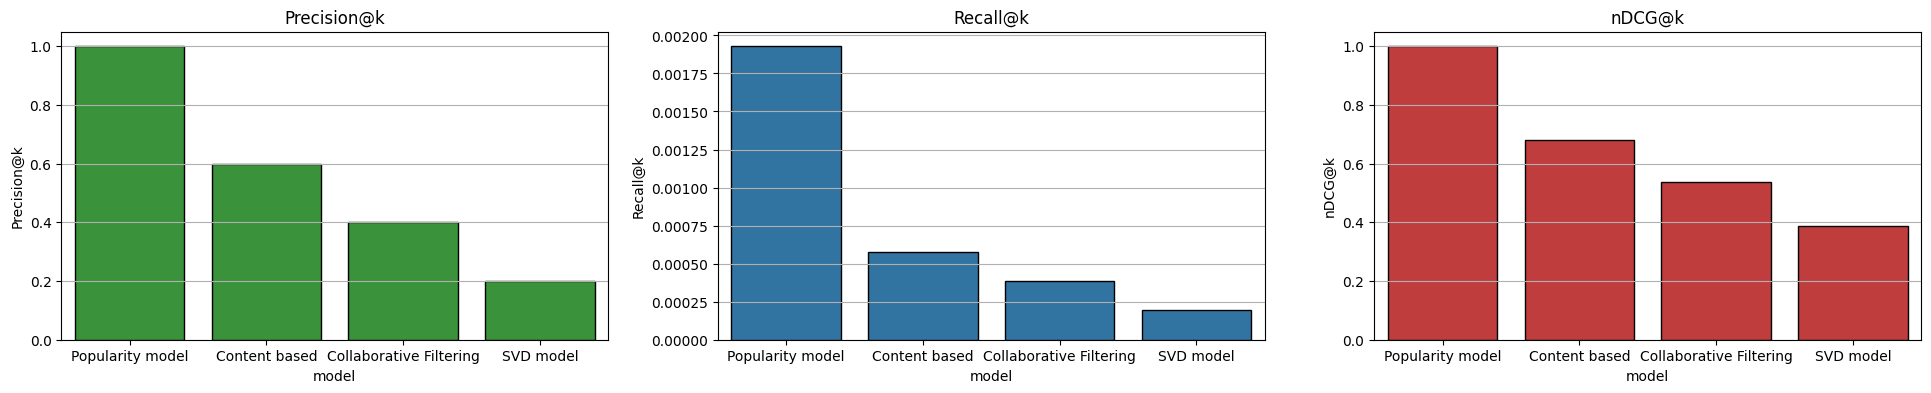

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(24, 4))

# Построение графиков
# precision
precision = sns.barplot(metrics_df, x=metrics_df.index, y='Precision@k', color='tab:green', edgecolor='black', ax=axes[0])
precision.set_title('Precision@k')
precision.set_xlabel('model')
precision.grid(axis='y')

# recall
recall = sns.barplot(metrics_df, x=metrics_df.index, y='Recall@k', color='tab:blue', edgecolor='black', ax=axes[1])
recall.set_title('Recall@k')
recall.set_xlabel('model')
recall.grid(axis='y')

# ndcg
ndcg = sns.barplot(metrics_df, x=metrics_df.index, y='nDCG@k', color='tab:red', edgecolor='black', ax=axes[2])
ndcg.set_title('nDCG@k')
ndcg.set_xlabel('model')
ndcg.grid(axis='y')

Метрики Precision@k, Recall@k, nDCG@k положительно оценивают только книги со средним рейтингом больше > 4.

**Precision@k (доля релевантных в топ-K)**
+ Popularity — наилучшая (1.0): всегда рекомендует популярные книги.
+ Content-Based — хорошая (0.6): учитывает схожесть по тегам.
+ CF — средняя (0.4): учитывает поведение похожих пользователей.
+ SVD — ниже всего (0.2): мало релевантных по среднему рейтингу, но книги могут быть интересны пользователю по другим признакам

**2. Recall@k (доля релевантных в топ-K среди всех релевантных)**
+ Все модели имеют очень низкий recall (< 0.2%).
+ Это означает, что модели не находят большинство релевантных (с рейтингом больше 4) книг.

**3. nDCG@k (учитывает порядок и релевантность)**
+ Popularity — наилучшая (1.0): ранжирует популярные книги, и они релевантны.
+ Content-Based — хорошая (0.68): учитывает семантику.
+ CF — средняя (0.54): учитывает поведение.
+ SVD — ниже всех (0.39): предсказания не очень точные.

## <center> **6. Гибридная модель**

In [42]:
ratings.groupby('user_id')['rating'].count()

user_id
1         3
2         3
3         2
4         3
5         5
         ..
53420     6
53421     8
53422    18
53423     2
53424    16
Name: rating, Length: 53424, dtype: int64

In [43]:
rated_books_by_user = list(ratings[ratings['user_id'] == 588]['book_id'])
np.random.choice(rated_books_by_user)

25

In [ ]:
class HybridWeightedRecommender():
    """Адаптивная гибридная модель.
    Выбирает стратегию в зависимости от количества оценок пользователя"""
    # Конструктор класса
    def __init__(self, ratings: pd.DataFrame, books_df: pd.DataFrame, book_tags: pd.DataFrame, tags: pd. DataFrame, weights: dict, k: int = 5):
        self.ratings = ratings # Данные оценок книг пользователями
        self.books_df = books_df # Данные о книгах 
        self.book_tags = book_tags # Связь между книгами и тегами
        self.tags = tags # Связь id тега и его названия
        self.weights = weights # Веса для взвешенной модели
        self.k = k # Количество книг в выдаче 
        self.user_id = -1 # id пользователя
        self.popularity_model = PopularityRecommender(k=self.k) # Модель популярности        
        self.content_model = ContentRecommender() # Контентная модель        
        self.cf_model = CFRecommender() # Модель коллаборативной фильтрации        
        self.svd_model = SVDRecommender(self.ratings, self.books_df) # Модель SVD
    
    # Подсчет количества оценок 
    def get_user_rating_count(self, user_id):
        """Возвращает количество оценок,
        которые поставил пользователь книгам"""
        # Проверяем есть ли пользователь в датасете
        if user_id not in self.ratings['user_id'].values:
            print(f'Пользователь {user_id} в ratings не найден')
        # Возвращаем количество оценок
        self.user_id = user_id
        return self.ratings[self.ratings['user_id'] == user_id].shape[0]
    
    # Рекомендации
    def recommend(self):
        """В зависимости от оценки пользователя, метод выбирает тип модели. 
        К итоговой оценке добавляет веса в зависимости от вклада модели"""
        # Количество, выставленных пользователем оценок
        rating_count = self.get_user_rating_count(self.user_id)
        
        # Если пользователь не поставил ни одной оценки
        # или это новый пользователь (нет в ratings)
        if rating_count == 0 or self.user_id not in self.ratings['user_id']:
            # Используем модель популярности
            self.popularity_model.fit(self.books_df)
            print('Popularity Recommender')
            return self.popularity_model.recommend()
        
        # Если пользователь поставил мало оценок от 1 до 8 (медианное количество)
        elif 1 <= rating_count <= 8:
            # Обучаем контентную модель
            self.content_model.fit(self.books_df, self.book_tags, self.tags)
            # Формируем список книг, оцененных пользователем
            rated_books_by_user = list(self.ratings[self.ratings['user_id'] == self.user_id]['book_id'])
            # Ищем книги, которые есть в content model
            available_book = [] # Доступные книги
            # Перебираем id книг в оцененных книгах
            for book_id in rated_books_by_user:
                # Если книга есть в словаре векторов
                if book_id in self.content_model.book_vectors:
                    available_book.append(book_id)
                    break 
                                
            # Если доступной книги нет, применяем popularity model
            if not available_book:
                print('Нет доступных книг для контентной рекомендации')
                self.popularity_model.fit(self.books_df)
                print('Popularity Recommender')
                return self.popularity_model.recommend()            
            
            print(available_book)
            # Из списка выбираем случайную книгу, для контентной рекомендации
            book_to_recommend = np.random.choice(available_book)
            # Используем контентную модель
            self.content_model.fit(self.books_df, self.book_tags, self.tags)
            print('Content Recommender')
            return self.content_model.recommend(book_to_recommend, self.k)
        
        # Если пользователь поставил больше 8 оценок
        else:
            print('Hybrid Weighted Recommender')
            # Используем взвешенную гибридную модель
            # Обучаем популярную модель
            self.popularity_model.fit(self.books_df)
            # Получаем рекомендации от популярной модели
            pop_rec = self.popularity_model.recommend()
            
            # Для контентной модели ищем доступные книги
            # Обучаем контентную модель
            self.content_model.fit(self.books_df, self.book_tags, self.tags)
            available_book = [] # Доступные книги
            # Перебираем id книг в оцененных книгах
            for book_id in rated_books_by_user:                
                if book_id in self.content_model.book_vectors:
                    available_book.append(book_id)
                    break 
                
            # Если есть доступные книги, получаем рекомендацию контентной модели
            if available_book:
                # Из списка выбираем случайную книгу, для контентной рекомендации
                book_to_recommend = np.random.choice(available_book)
                cont_rec = self.content_model.recommend(book_to_recommend, self.k)
                
            # Получаем рекомендации CF модели
            cf_model.fit(self.ratings, self.books_df)
            cf_rec = self.cf_model.recommend(self.user_id, self.k)
            
            # Получаем рекомендации от SVD модели
            train, test = svd_model.train_test_split() # Делим данные
            svd_model.fit(train)
            svd_rec = self.svd_model.recommend(self.user_id, self.k)
        
            scores = {} # Словарь с оценками для каждой книги
            # Добавляем оценки от каждой модели
            for df, model_name in zip([pop_rec, cont_rec, cf_rec, svd_rec], ['popularity', 'content', 'cf', 'svd']):
                # Пропускаем пустые датафреймы
                if df.empty:
                    continue
                weight = self.weight[model_name] # Получаем веса модели
                
                
            
    
        
        



In [ ]:
weights = {'popularity': 0.1, 'content': 0.2, 'cf': 0.3, 'svd': 0.3}
ex = HybridWeightedRecommender(ratings, books, book_tags, tags, weights, 5)
ex.get_user_rating_count(2)
ex.recommend()

[9762]
Content Recommender


,authors,original_title,average_rating
book_id,,,
1963638,Michael A. Singer,The Untethered Soul,4.269531
7015403,Brené Brown,The Gifts of Imperfection,4.171875
6596,Miguel Ruiz,The Four Agreements: A Practical Guide to Pers...,4.121094
653396,Susan Jeffers,Feel The Fear And Do It Anyway: How to Turn Yo...,4.011719
23317538,Brené Brown,Rising Strong,4.191406
